# Insight HD data challenge
## by Pedro de Bruin

This notebook contains my solution to the Week 5 Insight data challenge that was given to Health Data Science Fellows. 

## Instructions

Your task is to develop a model that predicts whether a biopsied breast cell is benign (not harmful) or malignant (cancerous), given a set of attributes about the cell.

Take no more than 3 hours to work on this. We've blocked off an hour at 4pm on Friday for both DS and HD Fellows to discuss what you found, and have some volunteers present how they approached the problem.

We highly recommend making a Jupyter Notebook to display your results. Please include:

    - A few sentence introduction to the problem
    - Data exploration
    - Graphs should be pretty and (short) take home messages should be provided
    - Modeling
        - Why you chose this method
        - How it performed
    - Summary of your results, what the take-home message/actionable insight is

This shouldn't be a dump of everything that you did, but only the important things/what worked/what was interesting/how you thought about the problem. The code should be clean, modular and well-commented.

## The data

The data is located at https://app.salesforceiq.com/r?target=5bbe5603c9e77c007a87c635&t=AFwhZf06FUgY_lxQ16f6-VmhuhZOnrgS06gkZCZucANRrKGag3eQaCtYO2cnX7hVORabEjGzAahlxo8V4MaU5E4low2CQRrb82wGsqDDO1ruU5O1J_Vtjd-myp0KLqs46lQpTegKZfxt&url=https%3A%2F%2Farchive.ics.uci.edu%2Fml%2Fmachine-learning-databases%2Fbreast-cancer-wisconsin%2Fbreast-cancer-wisconsin.data

The format of the data is 
1. Sample code number: id number 

2. Clump Thickness: 1 - 10 

3. Uniformity of Cell Size: 1 - 10 

4. Uniformity of Cell Shape: 1 - 10 

5. Marginal Adhesion: 1 - 10 

6. Single Epithelial Cell Size: 1 - 10 

7. Bare Nuclei: 1 - 10 

8. Bland Chromatin: 1 - 10 

9. Normal Nucleoli: 1 - 10 

10. Mitoses: 1 - 10 

11. Class: (2 for benign, 4 for malignant)

In [1]:
import urllib.request
import shutil
import warnings
warnings.filterwarnings('ignore')

In [2]:
localtarget = '/media/pedro/Seagate Backup Plus Drive/Insight/datasets/HDchallenge.csv'
dataurl = 'https://app.salesforceiq.com/r?target=5bbe5603c9e77c007a87c635&t=AFwhZf06FUgY_lxQ16f6-VmhuhZOnrgS06gkZCZucANRrKGag3eQaCtYO2cnX7hVORabEjGzAahlxo8V4MaU5E4low2CQRrb82wGsqDDO1ruU5O1J_Vtjd-myp0KLqs46lQpTegKZfxt&url=https%3A%2F%2Farchive.ics.uci.edu%2Fml%2Fmachine-learning-databases%2Fbreast-cancer-wisconsin%2Fbreast-cancer-wisconsin.data'

with urllib.request.urlopen(dataurl) as response, open(localtarget, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)

## Time for some Exploratory data analysis!

Begin by doing the basic imports, reading the csv into a dataframe and adding column names:

In [3]:
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv(localtarget, header=None, names=['id', 'clump_thickness', 'uniform_cellsize', 'uniform_cellshape', 
                                      'marginal_adhesion', 'single_epithelial_cellsize', 'bare_nuclei',
                                      'bland_chromatin', 'normal_nucleoli', 'mitoses', 'class'])

Now let's see what we got:

In [5]:
df.head()

,id,clump_thickness,uniform_cellsize,uniform_cellshape,marginal_adhesion,single_epithelial_cellsize,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


Now let's do a quick info():

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
id                            699 non-null int64
clump_thickness               699 non-null int64
uniform_cellsize              699 non-null int64
uniform_cellshape             699 non-null int64
marginal_adhesion             699 non-null int64
single_epithelial_cellsize    699 non-null int64
bare_nuclei                   699 non-null object
bland_chromatin               699 non-null int64
normal_nucleoli               699 non-null int64
mitoses                       699 non-null int64
class                         699 non-null int64
dtypes: int64(10), object(1)
memory usage: 60.1+ KB


Interesting, one of the columns (*bare_nuclei*) is not a number. Let's take a quick look

In [7]:
df['bare_nuclei'].value_counts()

1     402
10    132
5      30
2      30
3      28
8      21
4      19
?      16
9       9
7       8
6       4
Name: bare_nuclei, dtype: int64

Aha! Seems we have 16 entries with value '?'. Unfortunately our dataset is small and dropping these rows would reduce it by over 2%. Instead, let's replace the '?' value with the mean of the column:

In [8]:
df.loc[df['bare_nuclei']=='?', 'bare_nuclei'] = df.loc[df['bare_nuclei']!='?', 'bare_nuclei'].astype(float).mean()
df['bare_nuclei'] = df['bare_nuclei'].astype(float)

In [9]:
df['bare_nuclei'].value_counts()

1.000000     402
10.000000    132
5.000000      30
2.000000      30
3.000000      28
8.000000      21
4.000000      19
3.544656      16
9.000000       9
7.000000       8
6.000000       4
Name: bare_nuclei, dtype: int64

In [10]:
df['bare_nuclei'].value_counts()

1.000000     402
10.000000    132
5.000000      30
2.000000      30
3.000000      28
8.000000      21
4.000000      19
3.544656      16
9.000000       9
7.000000       8
6.000000       4
Name: bare_nuclei, dtype: int64

### Any missing values?

In [11]:
cols = df.columns
for i in range(len(cols)):
    print("Column {} has {} na values".format(cols[i], sum(df.iloc[:,i].isna()) ) )

Column id has 0 na values
Column clump_thickness has 0 na values
Column uniform_cellsize has 0 na values
Column uniform_cellshape has 0 na values
Column marginal_adhesion has 0 na values
Column single_epithelial_cellsize has 0 na values
Column bare_nuclei has 0 na values
Column bland_chromatin has 0 na values
Column normal_nucleoli has 0 na values
Column mitoses has 0 na values
Column class has 0 na values


**No missing values!** Someone has provided us with a nice and clean table :)

In [12]:
df.describe()

,id,clump_thickness,uniform_cellsize,uniform_cellshape,marginal_adhesion,single_epithelial_cellsize,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.544656,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,3.601852,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


We see that we have 699 entries. Also we have no outliers and all columns are indeed from 1 to 10. Excellent!

### Changing target class values from (2,4) to (0,1)

I'm not sure what motivated the table to use 2 (4) for benign (malignant) tumors, but I prefer the traditional (0,1) class values, so let's map 2->0, 4->1. 

In [13]:
df['class'].head()

0    2
1    2
2    2
3    2
4    2
Name: class, dtype: int64

In [14]:
targetdict = {2:0, 4:1}
df['class'] = df['class'].map(targetdict)

In [15]:
df['class'].head()

0    0
1    0
2    0
3    0
4    0
Name: class, dtype: int64

Perfect! Let's proceed with some basic plots:

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
df['class'].value_counts()

0    458
1    241
Name: class, dtype: int64

Text(0, 0.5, '# of entries')

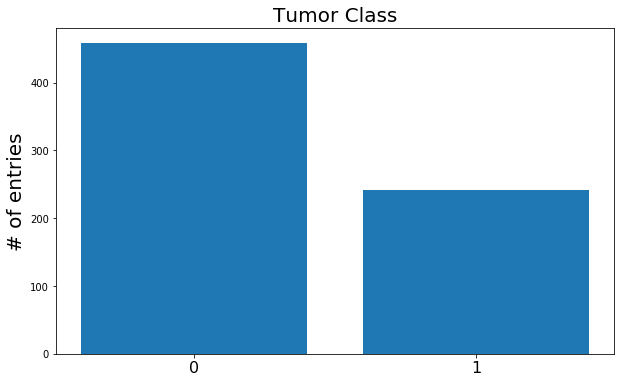

In [18]:
fig, ax = plt.subplots(figsize=(10,6))
plot1 = ax.bar(x=range(2), height = df['class'].value_counts())
plt.xticks(np.arange(0, 1.5, 1), fontsize=16)
ax.set_title('Tumor Class', fontsize=20)
ax.set_ylabel('# of entries', fontsize=20)

As expected of a cancer dataset, I'll probably need to deal with this **class imbalance** at some point.

### Plotting the other variables:

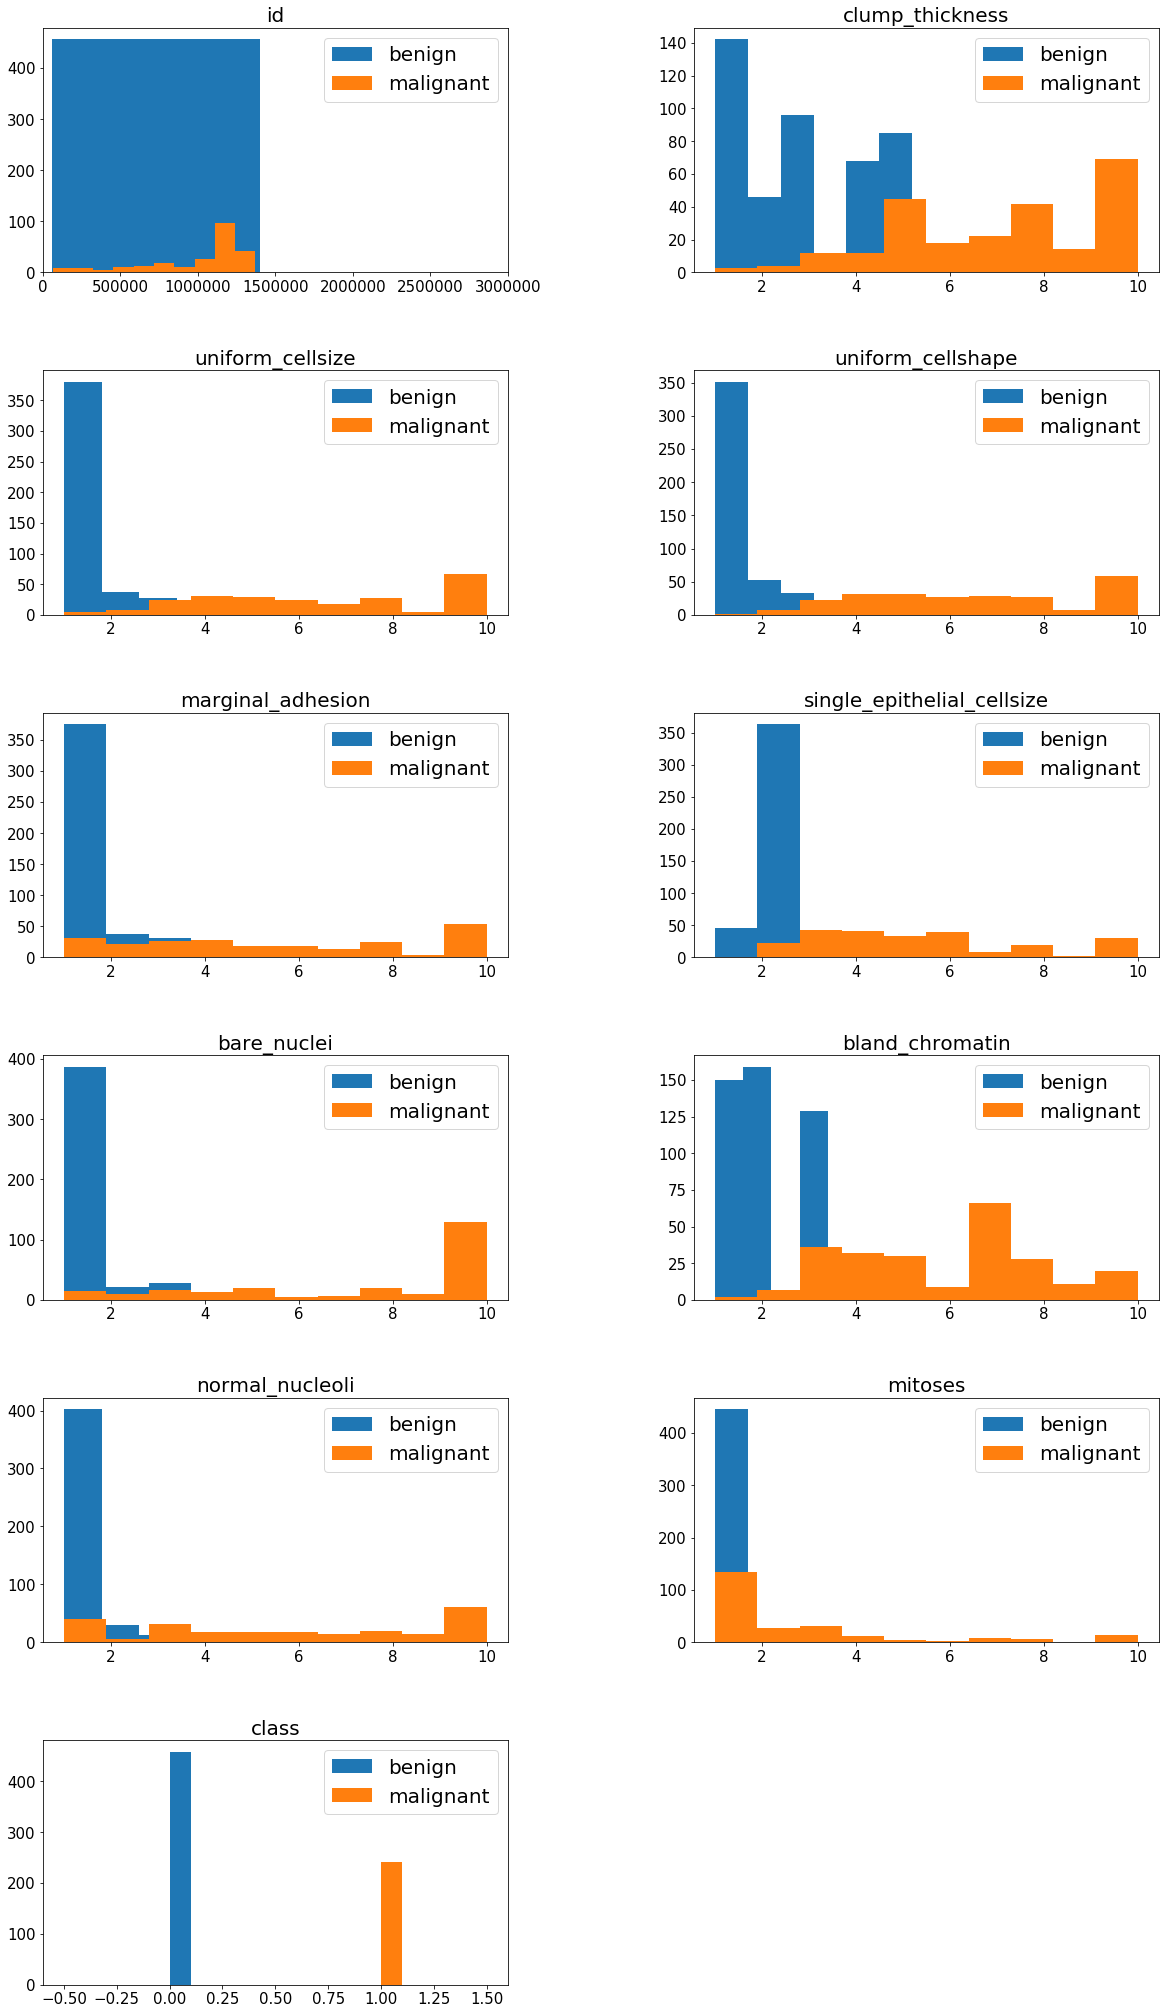

In [19]:
fig = plt.figure(figsize=(20,36))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, c in enumerate(cols):
    ax = fig.add_subplot(6, 2, i+1)
    sp0 = plt.hist(df.loc[df['class']==0, c], label='benign')
    sp1 = plt.hist(df.loc[df['class']==1, c], label='malignant')
    ax.legend(prop={'size':20})
    ax.set_title(c, fontsize=20)
    ax.tick_params(labelsize=15)
    if c=='id':
        ax.set_xlim([0,3000000])

As we can see, some variables have fantastic discrimination already!

## Partitioning data into train, xval and test sets

To make sure we are free of bias and training an optimal model, let's define 3 independent sets from the data. We will use a 70/15/15 partition

In [20]:
from sklearn.model_selection import train_test_split

Useful trick, split dataframe twice in a row: once for train/test, then split train into train/xval!

In [21]:
X_train, X_test, y_train, y_test = \
train_test_split(df.drop(columns=['class']), df['class'], test_size=0.2)

In [22]:
X_train, X_val, y_train, y_val \
    = train_test_split(X_train, y_train, test_size=0.125)

## Let's train some models!

We first use standard scaler on our datasets:

In [23]:
from sklearn.preprocessing import StandardScaler

In [24]:
dfs_to_scale = [X_train, X_val, X_test]
scaler = StandardScaler()
for x in dfs_to_scale:
    scaler.fit_transform(x)

## 1. Logistic regression

In [25]:
from sklearn.linear_model import LogisticRegression

Remember not to use 'id' to train the model!

In [26]:
model_features = X_train.drop(columns=['id']).columns
print("models will use the features {}".format(model_features))

models will use the features Index(['clump_thickness', 'uniform_cellsize', 'uniform_cellshape',
       'marginal_adhesion', 'single_epithelial_cellsize', 'bare_nuclei',
       'bland_chromatin', 'normal_nucleoli', 'mitoses'],
      dtype='object')


In [27]:
clf = LogisticRegression(solver='lbfgs').fit(X_train[model_features], y_train)

### Cross-validation prediction:

In [28]:
y_pred_val = clf.predict(X_val.drop(columns=['id']))
y_prob_val = clf.predict_proba(X_val.drop(columns=['id'])) 
clf.score(X_val.drop(columns=['id']), y_val)

0.9285714285714286

In [29]:
from sklearn.metrics import classification_report

In [30]:
print(classification_report(y_val, y_pred_val, target_names='class'))

             precision    recall  f1-score   support

          c       0.96      0.94      0.95        51
          l       0.85      0.89      0.87        19

avg / total       0.93      0.93      0.93        70



### Test set prediction:

In [31]:
y_pred_test = clf.predict(X_test.drop(columns=['id']))
y_prob_test = clf.predict_proba(X_test.drop(columns=['id'])) 
clf.score(X_test.drop(columns=['id']), y_test)

0.9857142857142858

Not bad... Let's take a look at precision, recall and F1-score:

In [32]:
logistic_regression_report = classification_report(y_test, y_pred_test, target_names='class')
print(logistic_regression_report)

             precision    recall  f1-score   support

          c       0.98      1.00      0.99        95
          l       1.00      0.96      0.98        45

avg / total       0.99      0.99      0.99       140



In [33]:
# The estimated coefficients will all be around 1:
#print(list(zip(clf.coef_[0], model_features))
coef_dict = {}
for coef, feat in zip(clf.coef_[0],model_features):
    coef_dict[feat] = coef

Text(0.5, 1.0, 'Feature Importance')

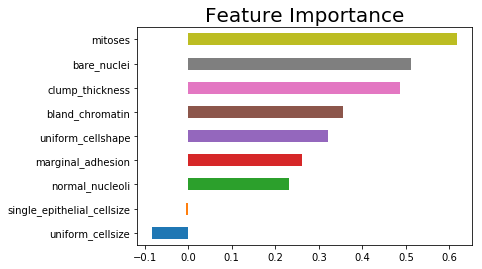

In [34]:
fig, ax = plt.subplots()    
feature_imp_series = pd.Series(coef_dict)
feature_imp_series.sort_values(ascending=True).plot(kind='barh');
ax.set_title('Feature Importance', fontsize=20)
#plt.barh(range(len(coef_dict)), list(coef_dict.values()), align='center');
#plt.yticks(range(len(coef_dict)), list(coef_dict.keys()));

## 2. Boosted Decision Tree

In [35]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [36]:
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),
                         algorithm="SAMME",
                         n_estimators=250)

clf.fit(X_train.drop(columns=['id']), y_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=250, random_state=None)

### Cross-validation prediction:

In [37]:
y_pred_val = clf.predict(X_val.drop(columns=['id']))
y_prob_val = clf.predict_proba(X_val.drop(columns=['id'])) 
clf.score(X_val.drop(columns=['id']), y_val)

0.9285714285714286

In [38]:
print(classification_report(y_val, y_pred_val, target_names='class'))

             precision    recall  f1-score   support

          c       0.96      0.94      0.95        51
          l       0.85      0.89      0.87        19

avg / total       0.93      0.93      0.93        70



### Test set prediction:

In [39]:
y_pred_test = clf.predict(X_test.drop(columns=['id']))
y_prob_test = clf.predict_proba(X_test.drop(columns=['id'])) 
clf.score(X_test.drop(columns=['id']), y_test)

0.9785714285714285

In [40]:
bdt_report = classification_report(y_test, y_pred_test, target_names='class')
print(bdt_report)

             precision    recall  f1-score   support

          c       0.98      0.99      0.98        95
          l       0.98      0.96      0.97        45

avg / total       0.98      0.98      0.98       140



## 3. Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [42]:
clf = RandomForestClassifier(n_estimators=500, max_depth=7)
clf.fit(X_train.drop(columns=['id']), y_train)
print(clf.feature_importances_)

[0.03991592 0.28378416 0.23061401 0.02778147 0.07646182 0.19215099
 0.0821518  0.05864145 0.00849839]


### Cross-validation prediction:

In [43]:
y_pred_val = clf.predict(X_val.drop(columns=['id']))
y_prob_val = clf.predict_proba(X_val.drop(columns=['id'])) 
clf.score(X_val.drop(columns=['id']), y_val)

0.9428571428571428

In [44]:
print(classification_report(y_val, y_pred_val, target_names='class'))

             precision    recall  f1-score   support

          c       0.98      0.94      0.96        51
          l       0.86      0.95      0.90        19

avg / total       0.95      0.94      0.94        70



### Test set prediction:

In [45]:
y_pred_test = clf.predict(X_test.drop(columns=['id']))
y_prob_test = clf.predict_proba(X_test.drop(columns=['id'])) 
clf.score(X_test.drop(columns=['id']), y_test)

0.9785714285714285

In [46]:
rf_report = classification_report(y_test, y_pred_test, target_names='class')
print(rf_report)

             precision    recall  f1-score   support

          c       0.97      1.00      0.98        95
          l       1.00      0.93      0.97        45

avg / total       0.98      0.98      0.98       140



## 4. Support Vector Machine

In [47]:
from sklearn.svm import SVC

In [48]:
clf = SVC(C=10., class_weight='balanced', gamma='auto', kernel='rbf')
clf.fit(X_train.drop(columns=['id']), y_train)

SVC(C=10.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Cross-validation prediction:

In [49]:
y_pred_val = clf.predict(X_val.drop(columns=['id']))
clf.score(X_val.drop(columns=['id']), y_val)

0.9285714285714286

In [50]:
print(classification_report(y_val, y_pred_val, target_names='class'))

             precision    recall  f1-score   support

          c       0.98      0.92      0.95        51
          l       0.82      0.95      0.88        19

avg / total       0.94      0.93      0.93        70



### Test set prediction:

In [51]:
y_pred_test = clf.predict(X_test.drop(columns=['id']))
clf.score(X_test.drop(columns=['id']), y_test)

0.9857142857142858

In [52]:
svc_report = classification_report(y_test, y_pred_test, target_names='class')
print(svc_report)

             precision    recall  f1-score   support

          c       0.99      0.99      0.99        95
          l       0.98      0.98      0.98        45

avg / total       0.99      0.99      0.99       140



# Summary

We have trained several classifiers on our dataset. Because the dataset is small and with few features, simple logistic regression performs quite well. 

**The classifiers have similar performance, with F1-scores, precision and recall usually ranging from 95% to 99%. The variation is due to the random train/test splitting procedure. We need more data to identify the 'best' one, but they are all already quite good.**

**Our analysis also indicates the 3 most importance features for our prediction are mitoses, clump thickness, bare nuclei and bland chromatin**.

<br><br><br><br>
## Classifier scores:

### Logistic Regression: 

In [53]:
print(logistic_regression_report)

             precision    recall  f1-score   support

          c       0.98      1.00      0.99        95
          l       1.00      0.96      0.98        45

avg / total       0.99      0.99      0.99       140



### Boosted Decision Tree:

In [54]:
print(bdt_report)

             precision    recall  f1-score   support

          c       0.98      0.99      0.98        95
          l       0.98      0.96      0.97        45

avg / total       0.98      0.98      0.98       140



### Random Forest:

In [55]:
print(rf_report)

             precision    recall  f1-score   support

          c       0.97      1.00      0.98        95
          l       1.00      0.93      0.97        45

avg / total       0.98      0.98      0.98       140



### Support Vector Machine:

In [56]:
print(svc_report)

             precision    recall  f1-score   support

          c       0.99      0.99      0.99        95
          l       0.98      0.98      0.98        45

avg / total       0.99      0.99      0.99       140

